# **_ID3 Algorithm_**

- [ID3 Logic](https://www.youtube.com/watch?v=K-oGwFoCGU0)
- [ID3 Machine Learning](https://www.youtube.com/watch?v=KjkE0aB29FM)
- [ID3 Example 1](https://www.youtube.com/watch?v=coOTEc-0OGw)
- [ID3 Example 2](https://www.youtube.com/watch?v=JO2wiZif2OM)
- [ID3 Example 3](https://www.youtube.com/watch?v=2A8AGfxs0D8)

<br>

### __*Import Libraries*__

In [1]:
import numpy as np
import pandas as pd
from typing import Union
from graphviz import Digraph

<br>

### __*ID3 Class*__

In [2]:
class Node:
    def __init__(self, feature=None, value=None, result=None) -> None:
        self.feature = feature  # Feature to split on
        self.value = value      # Value of the feature to split on
        self.result = result    # Result if the node is a leaf node
        self.children = {}      # Dictionary to store child nodes

    def show(self):
        print(f'Split on {self.feature} of value {self.value}\n'
              f'Result: {self.result}\n'
              f'Chaining: {self.children}')


class ID3:
    def __init__(self, dataframe : pd.DataFrame, outp_idx : int = -1) -> None:
        self.__dataframe = dataframe
        self.__outp_idx = outp_idx

        # Prepare the data
        self.__labels = list(self.__dataframe.columns)
        self.__X = self.__dataframe.drop(self.__labels[self.__outp_idx], axis=1).copy()
        self.__y = self.__dataframe[self.__labels[self.__outp_idx]].copy()

        self.__features = list(self.__X.columns)

        # Create Tree
        self.__tree = self.__fit()


    def __entropy(self, y=None) -> float:
        """ Calculate the entropy for an attribute"""
        y = self.__y if y is None else y

        unique, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()   #  calculates the probabilities of each unique label
        return -np.sum(probabilities * np.log2(probabilities))


    def __information_gain(self, feature):
        """ Calculate the information gain for a given feature """
        base_entropy = self.__entropy(self.__y)
        unique_values = np.unique(self.__X[feature])
        weighted_entropy = 0

        for value in unique_values:
            subset_y = self.__y[self.__X[feature] == value]
            weighted_entropy += len(subset_y) / len(self.__y) * self.__entropy(subset_y)

        return base_entropy - weighted_entropy


    def __fit(self, X=None, y=None, features=None) -> Node:
        X = self.__X if X is None else X
        y = self.__y if y is None else y
        features = self.__features if features is None else features

        # Base cases
        if len(np.unique(y)) == 1:
            return Node(result=y.iloc[0])

        if len(features) == 0:
            return Node(result=np.unique(y).argmax())

        # Choose the best feature to split on
        best_feature = max(features, key=lambda feature: self.__information_gain(feature))

        # Create a new decision tree node
        root = Node(feature=best_feature)

        # Recursively build the tree for each value of the best feature
        for value in np.unique(X[best_feature]):
            subset_X = X[X[best_feature] == value]
            subset_y = y[X[best_feature] == value]
            root.children[value] = self.__fit(subset_X, subset_y, [feature for feature in features if feature != best_feature])

        return root


    def predict(self, sample:pd.DataFrame, node=None) -> Union[KeyError, Node]:
        """ Function to predict using the decision tree """
        node = self.__tree if node is None else node

        if node.result is not None:
            return node.result
        value = sample[node.feature]
        if value not in node.children:
            return KeyError('Invalid Label(-s)')
        child = node.children[value]
        return self.predict(sample, child)


    def get_tree(self) -> Node:
        return self.__tree

    def visualize_tree(self, node=None, dot=None, parent_name=None, edge_label=None, green='yes'):
        node = self.__tree if node is None else node

        if dot is None:
            dot = Digraph(comment='Decision Tree')
            dot.attr(size='8,5')
            dot.node_attr.update(style='filled', fillcolor='lightblue', shape='box', fontname='arial', fontsize='10')
            dot.edge_attr.update(fontname='arial', fontsize='8')

        current_name = str(id(node))
        if node.feature is not None:
            dot.node(current_name, label=f'{node.feature}\n{edge_label}', fillcolor='lightblue')
        else:
            dot.node(current_name, label=f'Result: {node.result}', shape='ellipse', fillcolor='lightgreen') if node.result == green\
                else dot.node(current_name, label=f'Result: {node.result}', shape='ellipse', fillcolor='lightcoral')

        if parent_name is not None:
            dot.edge(parent_name, current_name, label=edge_label)

        for value, child_node in node.children.items():
            self.visualize_tree(child_node, dot, current_name, str(value))

        return dot

<br>

### __*[Tennis Dataset](https://www.kaggle.com/datasets/krishnagiri/id3csv) Preparation*__

In [3]:
tennis_df = pd.read_csv('data/tennis.csv')
tennis_df.head(14)

,Outlook,Temperature,Humidity,Wind,Answer
0,sunny,hot,high,weak,no
1,sunny,hot,high,strong,no
2,overcast,hot,high,weak,yes
3,rain,mild,high,weak,yes
4,rain,cool,normal,weak,yes
5,rain,cool,normal,strong,no
6,overcast,cool,normal,strong,yes
7,sunny,mild,high,weak,no
8,sunny,cool,normal,weak,yes
9,rain,mild,normal,weak,yes


<br>

### __*Create a Decision Tree*__

In [4]:
# Build the Model
tennis_model = ID3(tennis_df)

# Basic Test of the Model
prediction = tennis_model.predict(tennis_df.iloc[0])
print(f'The predicted result for the sample is: {prediction}')

The predicted result for the sample is: no


<br>

### __*Show the Decision Tree*__

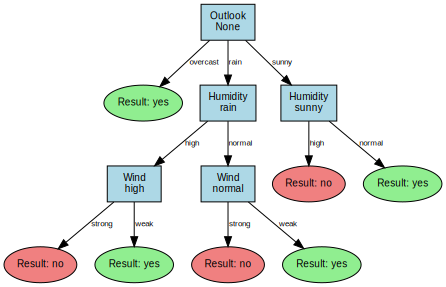

In [5]:
# Visualize the tree
tennis_model.visualize_tree()

<br>

### __*[Gender Dataset](https://www.kaggle.com/datasets/elakiricoder/gender-classification-dataset) Preparation*__

In [6]:
gender_df = pd.read_csv('data/gender_class.csv')

size = 0.8
split = int(len(gender_df)*size)

gender_df_train = gender_df.iloc[:split]
gender_df_test = gender_df[split:]

gender_df.head(10)

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female
5,1,13.0,6.8,1,1,1,1,Male
6,1,15.3,6.2,1,1,1,0,Male
7,0,13.0,5.2,0,0,0,0,Female
8,1,11.9,5.4,1,0,1,1,Female
9,1,12.1,5.4,0,0,0,0,Female


<br>

### __*Train Model*__

In [7]:
# Build the Model
gender_model = ID3(gender_df_train)

# Basic Test of the Model
prediction = gender_model.predict(gender_df.iloc[0])
print(f'The predicted result for the sample is: {prediction}')

The predicted result for the sample is: Male


<br>

### __*Test Model & Results*__

In [8]:
start = int(len(gender_df) - len(gender_df_test))
stop = len(gender_df)

correct = 0
for idx in range(start, stop):
    if gender_model.predict(gender_df.iloc[idx]) == gender_df.iloc[idx][-1]:
        correct += 1

print(f'Accuracy of the model is {(correct/len(gender_df_test)*100):.2f}%')

Accuracy of the model is 93.01%


In [9]:
gender_model.get_tree().show()

Split on distance_nose_to_lip_long of value None
Result: None
Chaining: {0: <__main__.Node object at 0x0000027D3630A520>, 1: <__main__.Node object at 0x0000027D363CAD00>}
